# Salary Analytics

This repository consists of conducting analysis on publicaly submitted salaries. The data was gathered and inspired by [Christen Nino De Guzman](https://www.linkedin.com/in/christenndg/) on her linkedin post about wage transparency. You can find the post [here](https://www.linkedin.com/feed/update/urn:li:activity:6883141659610234880/) and the associated csv [here](https://docs.google.com/spreadsheets/d/19h0WT9Xjf9ncNmJDWpd8fzz7YnB37nemDnxKSO0EE8o/edit#gid=1664289965). She advocated this on her linkedin community and it gained a lot of traction, nearly 60,000 people have anonomously submitted their total compensation breakdown, gender, age range, etc. The purpose of this article is to strictly do an analysis on the data retried. The article will consist of a few different segments as outlined below:

**Table of Contents**
- Data Retrieval
- Data Cleaning
- Analysis & Visualization
- Modelling
- Concluding Remarks
- Resources

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as pt

sns.set()

In [2]:
# constants
# source = https://docs.google.com/spreadsheets/d/19h0WT9Xjf9ncNmJDWpd8fzz7YnB37nemDnxKSO0EE8o/edit#gid=1664289965
file_path = './data/anon_salary.csv'

## Import Data

In [3]:
d = pd.read_csv(file_path)
d.shape

(59688, 22)

## Clean Data

During the cleaning components, we're not going to really aim for perfection as there's just too much data to parse through manually and too many individual edge cases which would act as outliers. We're aiming to clean the masses of the results that users have submitted. So the cleaning portion will most definetly not be perfect, but when dealing with a large volume of user submitted data without any options / restrictions in place for the submissions, it becomes almost impossible to have **perfectly** cleaned data. In this section we'll begin by renaming the columns to remove any fluf and wierd wording in them.

In [4]:
rename_cols = {
    'Timestamp' : 'timestamp',
    'Country' : 'country',
    'Age Range' : 'age_range',
    'Highest Level of Education Received' : 'max_edu',
    'Company Name' : 'org',
    'Years of Experience' : 'yoe',
    'Closest Major City and State (e.g. Santa Clara, CA)' : 'loc_city',
    'Annual Base Salary (if hourly, please convert to annual)' : 'annual_wage',
    'How many vacation days are you given per year?' : 'vacation_days_yearly',
    'How many sick days are you given per year?' : 'sick_days_yearly',
    'Do you openly discuss salary with your colleagues?' : 'open_wage_discussions',
    'How many months Maternity or Paternity does your company offer?' : 'maternity_leave_months',
    'Diverse Identity (Optional)' : 'ethnicity',
    'Currency (USD, CAD, etc)' : 'currency',
    'Gender (optional)' : 'gender',
    'Annual Bonus' : 'bonus',
    'Annual Average of RSUs' : 'avg_rsu',
    'Signing Bonus (if none, leave blank)' : 'signing_bonus',
    'Job Title' : 'job_title',
    'How many days per week are you required to work onsite/in the office?' : 'days_per_week_in_office'
}

d.rename(columns = rename_cols, inplace = True)
d.drop(columns = ['Unnamed: 20'], inplace = True)

In [5]:
curr_dct = {
    # I'm aware that dollars and $ can be across many different currencies, I'm making a generalized assumption
    'usd' : ['us dollar', 'us dollars', 'usda', 'usdp', 'dollars', '$', 'usa', 'uds', 'ysd', 'uss'],  
    'cad' : ['can', 'canadian', 'caf', 'canada'],
    'eur' : ['euro', 'euros', 'eu',],
    'gbp' : ['pound', 'pound sterling', 'pounds', 'british pounds', 'british pound', 'gbp £']
}

def clean_currency(cur, curr_dct = curr_dct):
    '''
    Will clean the currency column 
    '''
    cur = str(cur).lstrip().rstrip().strip().lower()
    for k,v in curr_dct.items():
        if cur in v:
            return k

    if cur == 'nan' or cur == 'n/a' or cur == '-':
        return np.nan
    return cur

In [6]:
def clean_wage(wage):
    '''
    Will clean the user input wage to be an integer
    '''
    wage=str(wage).lower()
    wage = wage.replace('$','').replace(' ', '').replace(',', '').replace('cad', '').replace('usd','').replace('()','').replace('k', '000')
    try:
        return int(wage)
    except:
        return np.nan

In [7]:
d['annual_wage'] = d['annual_wage'].apply(lambda x : clean_wage(x)).astype(float)

In [8]:
d['currency'] = d['currency'].apply(lambda x : clean_currency(x))

In [9]:
d['max_edu'].value_counts()

Bachelor's Degree                                             36936
Master's Degree                                               10082
Some College credit, no degree                                 4274
Associate Degree                                               1939
High School Graduate, Diploma or the equivalent (e.g. GED)     1786
Doctorate Degree                                               1205
Trade, Technical, Vocational Training                           737
Professional Degree                                             731
Some High School, No Diploma                                    207
No Schooling Completed                                          126
Name: max_edu, dtype: int64

In [10]:
def clean_org(org):
    '''
    This will clean the organization section. It will return np.nan if the user has not provided
    their organization, otherwise it will return the lowered organization passed
    '''
    
    na_list = ['prefer not to say', 'N/a', '-', 'nan', 'anon', 'anonymous', 'Prefer not to say']
    if str(org).lower().lstrip().rstrip() in na_list:
        return np.nan
    return str(org).rstrip().lstrip().lower()

d['org'] = d['org'].apply(clean_org)

In [62]:
def clean_loc_city(city):
    city_dct = {
        'nyc' : ['new york, ny', 'nyc', 'new york', 'new york city, ny', 'new york city', 'new york, new york', 'ny', 'ny ny', 'new york new york', 'new york ny'],
        'la' : ['los angeles, ca', 'los angeles'],
        np.nan : ['nan', 'none', '-', 'n/a'],
        'toronto' : ['toronto', 'toronto, ontario', 'toronto, canada', 'toronto, on', 'toronto, ca'],
        'sf' : ['san francisco ca', 'sf', 'sf ca', 'sf, ca', 'sf, california', 'san francisco, ca', 'sf', 'san fransisco', 'san francisco']
    }
    city = str(city).lower().lstrip().rstrip()
    for k,v in city_dct.items():
        if city in v:
            return k
    cleaned_city = str(city).split(',')[0]
    return cleaned_city.lower().lstrip().rstrip()

d['loc_city'] = d['loc_city'].apply(clean_loc_city)

In [63]:
clean_loc_city('new york ny')

'nyc'

In [64]:
d[(d['country'] == 'usa') & (d['loc_city'] == 'nyc')].shape

(6347, 21)

In [61]:
d[(d['country'] == 'usa') & (d['loc_city'] == 'nyc')].annual_wage.median()

85000.0

In [60]:
d[(d['country'] == 'usa') & (d['loc_city'] == 'new york ny')]

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,avg_rsu,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity


In [12]:
def clean_country(country):
    country_dct = {
        'usa' : [
            'united stayes', 'united statea', 'united stares', 'united states', 'unites states', 'united state', 
            'california', 'new york', 'us', 'ny', 'united statws',  'usa', 'united states', 'united states of america',
            'america', 'u.s.a.', 'u.s.a', 'u.s', 'u.s.', 'ny', 'united stated', 'los angeles', 'untied states',
            'united statss', 'united sates', 'la', 'sacramento', 'ysa'
        ],
        'canada' : ['canada', 'ca', 'can'],
        'united kingdom' : ['united kingdom', 'uk', ''],
        np.nan : ['nan', 'n/a', 'none', '-']
    }
    country = str(country).lower().lstrip().rstrip()
    for k,v in country_dct.items():
        if country in v:
            return k
    return country
d['country'] = d['country'].apply(clean_country)

In [13]:
def clean_job(job):
    job_dct = {
        'swe' : ['swe', 'software engineer', ''],
        'nurse' : ['rn', 'registered nurse', 'nurse'],
        'data scientist' : ['data science', 'data scientist'],
        np.nan : ['nan', '-', 'none']
    }
    job = str(job).lstrip().rstrip().lower()
    for k,v in job_dct.items():
        if job in v:
            return k
    return job
d['job_title'] = d['job_title'].apply(clean_job)

In [14]:
def clean_gender(gender):
    gender_dct = {
        'female' : ['female'],
        'male' : ['male'],
        np.nan : ['prefer not to say', 'n/a', '-', "you shouldn't have included this free text field eh?"],
        'non-binary' : ['non-binary', 'non binary', 'nb', 'nonbinary'],
        'trans' : ['trans', 'transgender fem', 'genderqueer, transmasculine', 'trans female', 'trans man', 'trans male']
    }
    gender = str(gender).lower().lstrip().rstrip()
    for k,v in gender_dct.items():
        if gender in v:
            return k
        if 'binary' in gender:
            return 'non-binary'
    return 'other'
d['gender'] = d['gender'].apply(clean_gender)

In [15]:
def clean_yoe(yoe):
    yoe = str(yoe).lstrip().rstrip()
    if yoe == 'nan':
        return np.nan
    elif yoe == '20+':
        return '20+'
    else:
        try:
            return int(yoe)
        except:
            return yoe
d['yoe'] = d['yoe'].apply(clean_yoe)

In [16]:
d['signing_bonus'] = d['signing_bonus'].apply(clean_wage)
d['bonus'] = d['bonus'].apply(clean_wage)

In [17]:
def clean_sick_days(days):
    sick_dct = {
        'unlim' : ['as many as i want', 'as many as i need', 'infinite', 'unlimited', '🚩unlimited', 'no limit', 'pto', 'unlimited (kind of)', 'unlimited pto', '"unlimited"'],
        np.nan : ['none', 'nan', 'n/a', '-', '?', 'na', 'idk', 'not sure', 'unsure'],
        10 : ['2 weeks', '10 days', '14 days'],
        5 : ['1 week', '5 days', '7 days', '40 hours'],
        15 : ['3 weeks', '15 days', '21 days'],
        20 : ['4 weeks', '20 days'],
        25 : ['5 weeks', '25 days'],
        30 : ['30 days', '6 weeks']
    }
    days = str(days).lower().lstrip().rstrip().replace('"', '').replace('"', '')
    for k,v in sick_dct.items():
        if days in v:
            return k
    try:
        return int(days)
    except:
        return days
    
d['sick_days_yearly'] = d['sick_days_yearly'].apply(clean_sick_days)
d['vacation_days_yearly'] = d['vacation_days_yearly'].apply(clean_sick_days)

In [18]:
def clean_open_discussions(disc):
    disc_dct = {
        'yes' : ['yes', 'ya', 'yeah'],
        'no'  : ['no', 'nope', 'never']
    }
    
    disc = str(disc).lower().lstrip().rstrip()
    for k,v in disc_dct.items():
        for val in v:
            if val in disc:
                return k
    return 'other'
d['open_wage_discussions'] = d['open_wage_discussions'].apply(clean_open_discussions)

In [19]:
def clean_ethnicity(eth):
    eth_dct = {
        'caucasian' : ['white', 'caucasian', 'white female', 'white male'],
        'african american' : ['black', 'african', 'black american', 'black/african american', 'african american', 'black woman', 'african-american', 'black male', 'black man', 'black female'],
        'hispanic' : ['hispanic', 'latina', 'latino', 'latinx', 'mexican-american', 'latino/hispanic',  'mexican', 'mexico', 'mexican american', 'latin'],
        'asian' : ['asian', 'asian american', 'south asian', 'asian-american', 'korean', 'indian american', 'vietnamese', 'east asian', 'asian indian', 'asian woman', 'filipino', 'filipina', 'indian', 'chinese'],
        'middle eastern' : ['middle eastern', 'arab', 'pakistani'],
        'native' : ['native american', 'native', 'indigenous']
    }
    eth = str(eth).lower().lstrip().rstrip()
    
    for k,v in eth_dct.items():
        if eth in v:
            return k
    return 'unknown'

d['ethnicity'] = d['ethnicity'].apply(clean_ethnicity)

In [20]:
d['avg_rsu'] = d['avg_rsu'].apply(clean_wage)

In [21]:
def clean_mat_leave(mat):
    mat_dct = {
        np.nan : ['none', 'not sure', 'unsure','no', 'no idea', '?', 'idk', 'unknown', 'n/a', '-', "don't know", '0'],
        0.5 : ['2 weeks'],
        1 : ['1', '1 month'],
        1.5 : ['6 weeks', '1.5'],
        2 : ['2', '2 months', '8 weeks'],
        3 : ['3', '3 months', '12 weeks'],
        4 : ['4', '4 months', '16 weeks'],
        5 : ['5', '5 months', '20 weeks'],
        6 : ['6', '6 months', '24 weeks'],
        float('inf') : ['unlimited']
    }
    mat = str(mat).lower().lstrip().rstrip()
    for k,v in mat_dct.items():
        if mat in v:
            return k
    return 'unknown'

d['maternity_leave_months'] = d['maternity_leave_months'].apply(clean_mat_leave)

In [22]:
def clean_industry(ind):
    ind_dct = {
        'tech' : ['tech'],
        'finance' : ['fin tech', 'finance', 'fintech', 'financial services'],
        'heath care' : ['healthcare', 'health care', 'HospTechalTechy', 'healthcare tech'],
        'non profit' : ['nonproftech', 'non proftech', 'non profit']
    }
    ind = str(ind).lower().lstrip().rstrip()
    for k,v in ind_dct.items():
        if ind in v:
            return k
    return ind

d['Industry'] = d['Industry'].apply(clean_industry)

## Analysis / Visualization

Now since the data is cleaned up, we can move forward to the analysis component. Below I've outlined a series of questions which I want to answer with the available data.  
- convert wages, signing bonus, rsu to usd via currency  
- which industries have the highest median salary -- done
- which profession has the highest median salary -- done
- median wages per ethnic groups  -- done
- median wages per gender  -- done
- What is the median income per years of experience  -- done
- what is the median income per age group  -- done
- which locations pay better for same positions  
- which organizations pay the most -- done  
- how much does level of education translate to income   -- done

In [40]:
us_df = d[d['currency'] == 'usd'].copy()

In [24]:
def visualize_group(d, remove_vals, group_col, agg_col, title, th, n):
    '''
    Given a dataframe d, this function will filter the values and visualize the results
    based on the group and aggregate columns.
    
    params:
        d (DataFrame) : The dataframe with the data you're visualizing
        remove_vals (List) : The list of values you want to filter out of the input df
        group_col (String) : The column you want to group
        agg_col (String) : The column you want to aggregate the result of
        title (String) : The title of the plot
        th (Integer) : The threshold of values each group must have
        n (Integer) : The number of results you want to filter
        
    example:
        visualize_group(
            d = us_df,
            remove_vals = None, 
            group_col = 'job_title',
            agg_col = 'annual_wage',
            title = 'Top 15 Professions by Median Annual Wage',
            th = 3,
            n = 15
        )
    '''
    if remove_vals:
        d = d[~d[agg_col].isin(remove_vals)]
    
    df = d.groupby([group_col])[agg_col].agg(['count', 'mean', 'median']).reset_index().rename(columns = {
        'count' : group_col + '_count', 'mean' : 'avg_' + agg_col, 'median' : 'median_' + agg_col
    }).copy()
    
    df = df[df[group_col + '_count'] > th].sort_values(by = 'median_' + agg_col, ascending = False).copy()
    if n:
        df = df.head(n)
        
    plt.clf()
    plt.barh(y = df[group_col].values, width = df['median_' + agg_col])
    plt.ylabel(group_col)
    plt.xlabel("median_" + agg_col)
    plt.title(title)
    plt.show()

## Jobs with the Highest Median Salary

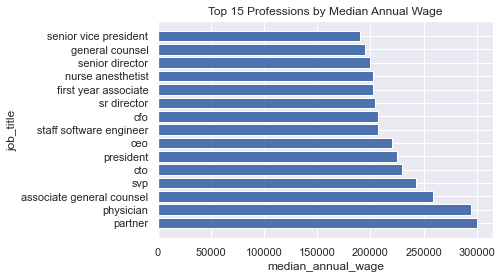

In [25]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'job_title',
    agg_col = 'annual_wage',
    title = 'Top 15 Professions by Median Annual Wage',
    th = 5,
    n = 15
)

## Industries with the Highest Median Salary

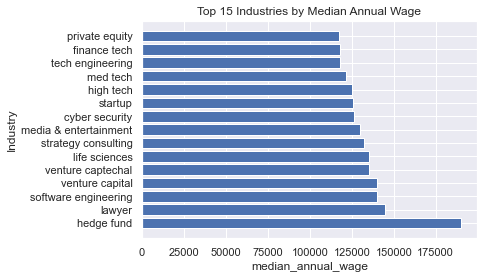

In [26]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'Industry',
    agg_col = 'annual_wage',
    title = 'Top 15 Industries by Median Annual Wage',
    th = 5,
    n = 15
)

## Average Income per YoE

In [36]:
yoe_df = d.copy()
yoe_df['yoe'] = yoe_df['yoe'].apply(lambda x : [20 if x == '20+' else x][0]).astype(float)

In [91]:
# visualize_group(
#     d = yoe_df,
#     remove_vals = None, 
#     group_col = 'yoe',
#     agg_col = 'annual_wage',
#     title = 'Median YoE per Year of Experience',
#     th = 5,
#     n = 20
# )

## Median Wages per Gender

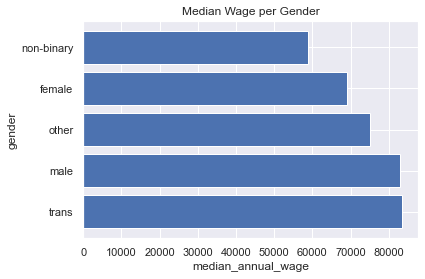

In [28]:
visualize_group(
    d = yoe_df,
    remove_vals = None, 
    group_col = 'gender',
    agg_col = 'annual_wage',
    title = 'Median Wage per Gender',
    th = 5,
    n = 20
)

## Median Wages per Ethnic Group  

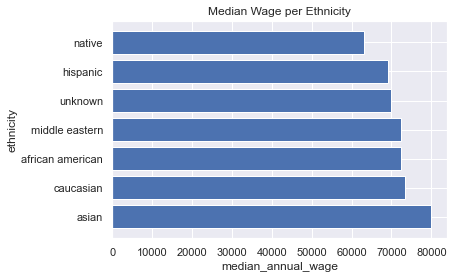

In [29]:
visualize_group(
    d = yoe_df,
    remove_vals = None, 
    group_col = 'ethnicity',
    agg_col = 'annual_wage',
    title = 'Median Wage per Ethnicity',
    th = 5,
    n = 20
)

## Median Wages per Age Group

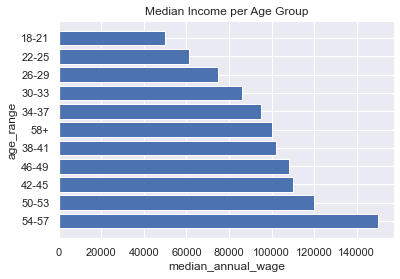

In [30]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'age_range',
    agg_col = 'annual_wage',
    title = 'Median Income per Age Group',
    th = 5,
    n = None
)

## Highest Paying Organizations

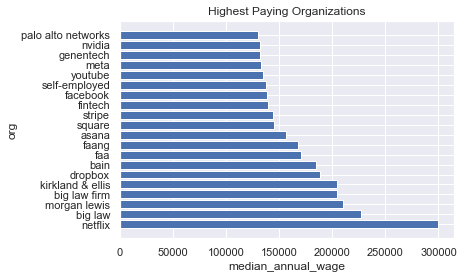

In [31]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'org',
    agg_col = 'annual_wage',
    title = 'Highest Paying Organizations',
    th = 5,
    n = 20
)

## Median Wages per Maximum Education Level

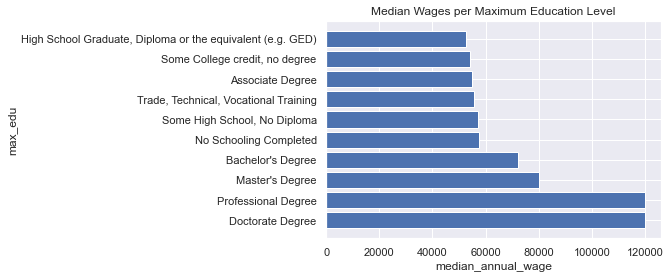

In [32]:
visualize_group(
    d = us_df,
    remove_vals = None, 
    group_col = 'max_edu',
    agg_col = 'annual_wage',
    title = 'Median Wages per Maximum Education Level',
    th = 5,
    n = None
)

## Highest Paying Locations

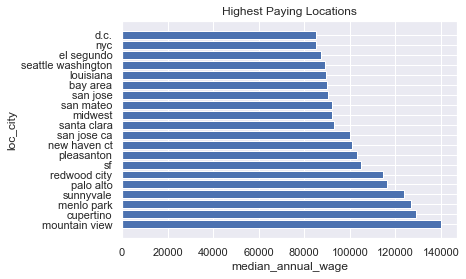

In [65]:
visualize_group(
    d = d[d['country'] == 'usa'],
    remove_vals = None, 
    group_col = 'loc_city',
    agg_col = 'annual_wage',
    title = 'Highest Paying Locations',
    th = 5,
    n = 20
)

In [71]:
res = d['loc_city'].apply(lambda x : [x if x in ['new', 'ny'] else np.nan][0])

In [74]:
d[d['loc_city'] == 'cupertino']

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,avg_rsu,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity
4345,12/7/2021 4:13:36,26-29,2,tech engineering,swe,apple,"Some College credit, no degree",cupertino,usa,130000.0,...,50000.0,13000.0,usd,NaN,NaN,3,other,unknown,female,unknown
7269,12/7/2021 9:57:49,26-29,4,tech,product development coordinator,apple,Bachelor's Degree,cupertino,usa,86500.0,...,3000.0,NaN,usd,14,14,"None, I work fully remote",no,unknown,female,unknown
17859,12/7/2021 19:20:16,34-37,7,tech,software qa engineer,apple,Bachelor's Degree,cupertino,usa,122700.0,...,1660.0,NaN,usd,19 days,12,3,no,unknown,female,unknown
23553,12/7/2021 22:26:27,34-37,11,tech,swe,apple,Master's Degree,cupertino,usa,191000.0,...,110000.0,NaN,usd,20,NaN,3,other,3,female,unknown
31978,12/8/2021 2:27:44,22-25,1,tech,quality engineer,apple,Bachelor's Degree,cupertino,usa,120000.0,...,12000.0,20000.0,usd,NaN,NaN,NaN,yes,unknown,male,unknown
32575,12/8/2021 3:21:52,26-29,3,tech,research scientist/engineer,apple,Bachelor's Degree,cupertino,usa,137000.0,...,40000.0,5000.0,usd,15,15,"None, I work fully remote",yes,unknown,female,unknown
35929,12/8/2021 10:01:12,22-25,1,e-commerce,fraud associate,poshmark,Bachelor's Degree,cupertino,usa,62000.0,...,2500.0,NaN,usd,15,5,"None, I work fully remote",no,1,male,unknown
43223,12/9/2021 12:56:02,22-25,1,consumer electronics,product design engineer intern,apple,Bachelor's Degree,cupertino,usa,129000.0,...,NaN,NaN,usd,NaN,NaN,"None, I work fully remote",no,unknown,male,unknown
44324,12/9/2021 16:13:37,34-37,10,corporate law,senior legal advisor,apple,Master's Degree,cupertino,usa,307000.0,...,22.0,NaN,usd,20,10,5,no,4,male,unknown
44673,12/9/2021 17:03:16,18-21,1,tech,software engineer intern,amazon,"Some College credit, no degree",cupertino,usa,140000.0,...,NaN,NaN,usd,NaN,NaN,NaN,no,unknown,male,hispanic


In [94]:
d2= d.copy()
d2['is_ds'] = d2['job_title'].apply(lambda x : [True if str(x).lower() in ['data', 'science', 'data science', 'data scientist', 'research'] else False][0])

In [95]:
d2[d2['is_ds']==True].annual_wage.max()

209000.0

In [96]:
d2[(d2['is_ds'] == True) & (d2['annual_wage'] == 209000) ]

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity,is_ds
9879,12/7/2021 2:37:40,26-29,4,data science,data scientist,ibm,Master's Degree,sf,usa,209000.0,...,13000.0,usd,19,unlim,"None, I work fully remote",yes,6,male,unknown,True


In [ ]:
import pandas as pd
import requests
import numpy as np

In [75]:
levels_fyi_data = requests.get('https://www.levels.fyi/js/salaryData.json').json()
levels_df = pd.DataFrame(levels_fyi_data)
levels_df.shape

In [78]:
levels_df = levels_df.drop(['cityid', 'dmaid','rowNumber'], axis=1)
levels_df = levels_df.replace("", np.nan)

In [81]:
levels_df['timestamp'] = pd.to_datetime(levels_df['timestamp'])
levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
] = levels_df[
    ['yearsofexperience','basesalary','bonus','stockgrantvalue','totalyearlycompensation','yearsatcompany']
].apply(pd.to_numeric)

In [82]:
levels_df

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,NaN,107.0,20.0,10.0,NaN,NaN
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,NaN,155.0,NaN,NaN,NaN,NaN
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,NaN,169000.0,100000.0,30000.0,NaN,NaN
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,173.0,"Vancouver, BC, Canada",11.0,1.0,NaN,120000.0,0.0,53000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,2021-08-17 08:16:36,Amazon,L6,Product Manager,241.0,"Seattle, WA",9.0,0.0,Analytic,150.0,46.0,45.0,Female,"Title: Senior Product Manager, Race: Asian, Ac..."
62638,2021-08-17 08:22:17,Fidelity Investments,L3,Software Engineer,98.0,"Durham, NC",0.0,0.0,Full Stack,85.0,0.0,13.0,Male,"10% profit share into 401k and 7% 401k match, ..."
62639,2021-08-17 08:24:56,Cisco,Grade 8,Software Engineer,154.0,"San Jose, CA",5.0,5.0,Networking,129.0,10.0,15.0,Male,"Title: Software Engineer 3, Race: Asian"
62640,2021-08-17 08:26:21,HSBC,GCB5,Software Engineer,159.0,"New York, NY",12.0,5.0,Full Stack,139.0,0.0,20.0,NaN,Title: Senior Software Engineer
